In [1]:
import numpy as np
import cupy as cp
import cupyx.scipy.ndimage as ndimage
import h5py
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.recon_methods import multiPaganin
from holotomocupy.utils import *
from holotomocupy.proc import remove_outliers
cp.cuda.Device(3).use()

astropy module not found
olefile module not found


<CUDA Device 3>

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 2048  # object size in each dimension
pad = n//8 # pad for the reconstructed probe
pos_step = 1 # steps in positions
npos = 18*18 # total number of positions
z1c = -17.75e-3 # [m] position of the CA
detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
z1 = np.tile(z1c, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size

extra=8
# sample size after demagnification
ne = (3072+512)//(2048//n)+2*pad
# extra = 16
# ne = 3096+2*pad+2*extra
show = True
lam_psi=0
lam_prb=0
path = f'/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/code2um_nfp18x18_01'
path_out = f'/data/vnikitin/ESRF/ID16A/20240924_rec/SiemensLH/code2um_nfp18x18_01_spaceFv5'

## Read data

[[[2314.72025294 -178.05540407]
  [2314.72025294  178.05540407]
  [2374.07205429  534.16621222]
  [2552.12745836  534.16621222]
  [2552.12745836  890.27702036]
  [2314.72025294 1187.03602715]
  [2433.42385565 1661.850438  ]
  [2492.77565701 2017.96124615]
  [2492.77565701 2017.96124615]
  [2314.72025294 2492.77565701]]]
[[[2208. -300.]
  [2209.   54.]
  [2232.  492.]
  [2382.  560.]
  [2384.  907.]
  [2210. 1054.]
  [2277. 1654.]
  [2329. 2025.]
  [2329. 2025.]
  [2211. 2350.]]]


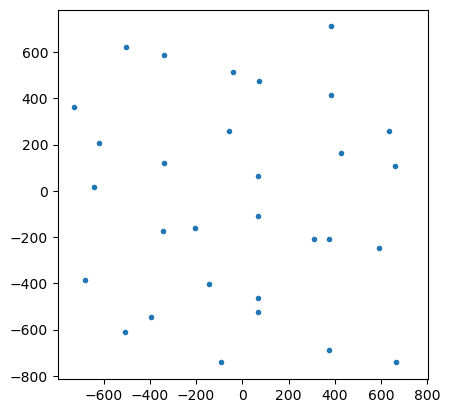

npos=30
-727.5 664.5
-742.0 711.0
4096
95.5 4000.5
49.0 4047.0
4096_256_30_0_frame


In [3]:
with h5py.File(f'{path}/code2um_nfp18x18_010000.h5') as fid:
    data0 = fid['/entry_0000/measurement/data'][:npos].astype('float32')
    
with h5py.File(f'{path}/ref_0000.h5') as fid:
    ref0 = fid['/entry_0000/measurement/data'][:].astype('float32')
with h5py.File(f'{path}/dark_0000.h5') as fid:
    dark0 = fid['/entry_0000/measurement/data'][:].astype('float32')

data0 = data0[np.newaxis]
shifts_code0 = np.loadtxt(f'/data/vnikitin/ESRF/ID16A/20240924/positions/shifts_code_nfp18x18ordered.txt')[np.newaxis,:,::-1]
shifts_code0 = shifts_code0/voxelsize*(2048//n)*1e-6
shifts_code0[:,:,1]*=-1

print(shifts_code0[:,-10:])
shifts_code0 = np.load(f'shifts_code_new.npy')
print(shifts_code0[:,-10:])

for k in range(int(np.log2(2048//n))):
    data0 = (data0[:,:,::2]+data0[:,:,1::2])*0.5
    data0 = (data0[:,:,:,::2]+data0[:,:,:,1::2])*0.5
    ref0 = (ref0[:,::2]+ref0[:,1::2])*0.5
    ref0 = (ref0[:,:,::2]+ref0[:,:,1::2])*0.5    
    dark0 = (dark0[:,::2]+dark0[:,1::2])*0.5
    dark0 = (dark0[:,:,::2]+dark0[:,:,1::2])*0.5    
shifts_code0/=(2048//n)

#centering
shifts_code0[:,:,1]-=(np.amax(shifts_code0[:,:,1])+np.amin(shifts_code0[:,:,1]))/2
shifts_code0[:,:,0]-=(np.amax(shifts_code0[:,:,0])+np.amin(shifts_code0[:,:,0]))/2
shifts_code0 = shifts_code0.reshape(1,int(np.sqrt(npos)),int(np.sqrt(npos)),2)
shifts_code0 = shifts_code0[:,::pos_step,::pos_step,:].reshape(1,npos//pos_step**2,2)
data0 = data0.reshape(1,int(np.sqrt(npos)),int(np.sqrt(npos)),n,n)
data0 = data0[:,::pos_step,::pos_step,:].reshape(1,npos//pos_step**2,n,n)

ids = np.where((np.abs(shifts_code0[0,:,0])<ne//2-n//2-pad-extra)*(np.abs(shifts_code0[0,:,1])<ne//2-n//2-pad-extra))[0]#[0:2]
data0 = data0[:,ids]
shifts_code0 = shifts_code0[:,ids]


plt.plot(shifts_code0[0,:,0],shifts_code0[0,:,1],'.')
plt.axis('square')
plt.show()

npos = len(ids)
print(f'{npos=}')
print(np.amin(shifts_code0[0,:,0]),np.amax(shifts_code0[0,:,0]))
print(np.amin(shifts_code0[0,:,1]),np.amax(shifts_code0[0,:,1]))
print(ne)
print(np.amin(ne//2-n//2-pad-extra-shifts_code0[0,:,0]),np.amax(ne//2+n//2+pad+extra+shifts_code0[0,:,0]))
print(np.amin(ne//2-n//2-pad-extra-shifts_code0[0,:,1]),np.amax(ne//2+n//2+pad+extra+shifts_code0[0,:,1]))

flg = f'{ne}_{pad}_{npos}_{lam_prb}_frame'
print(flg)

# Process data

Affected pixels: 28
Affected pixels: 25
Affected pixels: 23
Affected pixels: 23
Affected pixels: 30
Affected pixels: 22
Affected pixels: 25
Affected pixels: 19
Affected pixels: 24
Affected pixels: 21
Affected pixels: 21
Affected pixels: 29
Affected pixels: 32
Affected pixels: 29
Affected pixels: 30
Affected pixels: 32
Affected pixels: 26
Affected pixels: 27
Affected pixels: 23
Affected pixels: 20
Affected pixels: 22
Affected pixels: 28
Affected pixels: 24
Affected pixels: 29
Affected pixels: 24
Affected pixels: 29
Affected pixels: 24
Affected pixels: 22
Affected pixels: 29
Affected pixels: 24
Affected pixels: 13


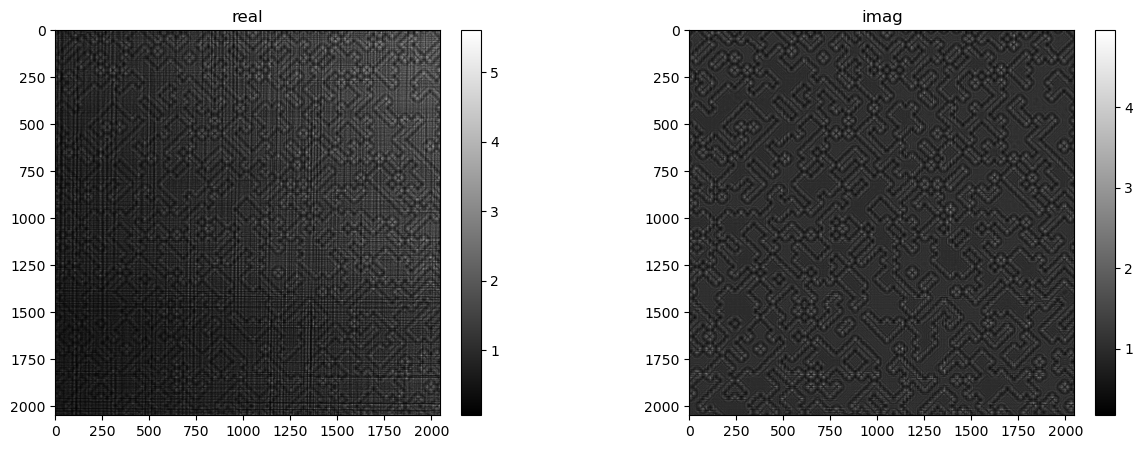

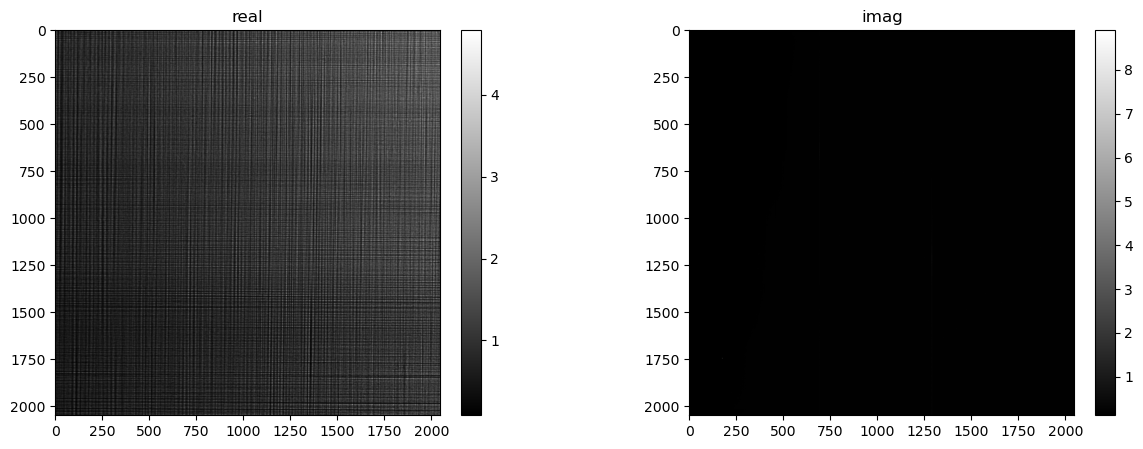

In [4]:
data = data0.copy()
ref = ref0.copy()
dark = dark0.copy()
dark = np.mean(dark,axis=0)[np.newaxis]
ref = np.mean(ref,axis=0)[np.newaxis]
data-=dark
ref-=dark

data[data<0]=0
ref[ref<0]=0
data[:,:,1320//3:1320//3+25//3,890//3:890//3+25//3] = data[:,:,1280//3:1280//3+25//3,890//3:890//3+25//3]
ref[:,1320//3:1320//3+25//3,890//3:890//3+25//3] = ref[:,1280//3:1280//3+25//3,890//3:890//3+25//3]
for k in range(npos):
    radius = 3
    threshold = 0.8
    data[:,k] = remove_outliers(data[:,k], radius, threshold)
    
ref[:] = remove_outliers(ref[:], radius, threshold)     
data/=np.mean(ref)
dark/=np.mean(ref)
ref/=np.mean(ref)

data[np.isnan(data)] = 1
ref[np.isnan(ref)] = 1

for k in range(int(np.log2(2048//n))):
    data = (data[:,:,::2]+data[:,:,1::2])*0.5
    data = (data[:,:,:,::2]+data[:,:,:,1::2])*0.5
    ref = (ref[:,::2]+ref[:,1::2])*0.5
    ref = (ref[:,:,::2]+ref[:,:,1::2])*0.5    
    dark = (dark[:,::2]+dark[:,1::2])*0.5
    dark = (dark[:,:,::2]+dark[:,:,1::2])*0.5  

rdata = data/(ref+1e-11)

mshow_complex(data[0,0]+1j*rdata[0,0],show)
mshow_complex(ref[0]+1j*dark[0],show)

# Multipaganin

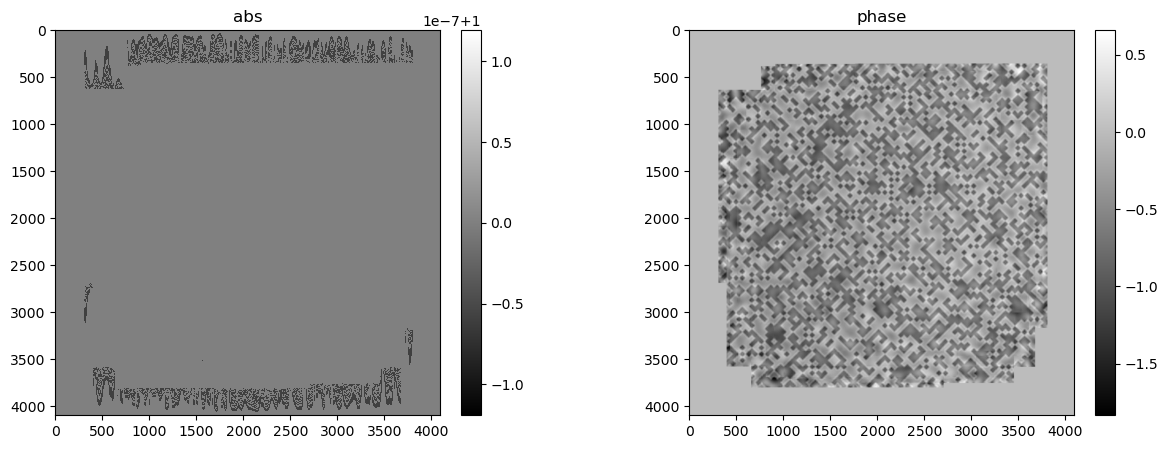

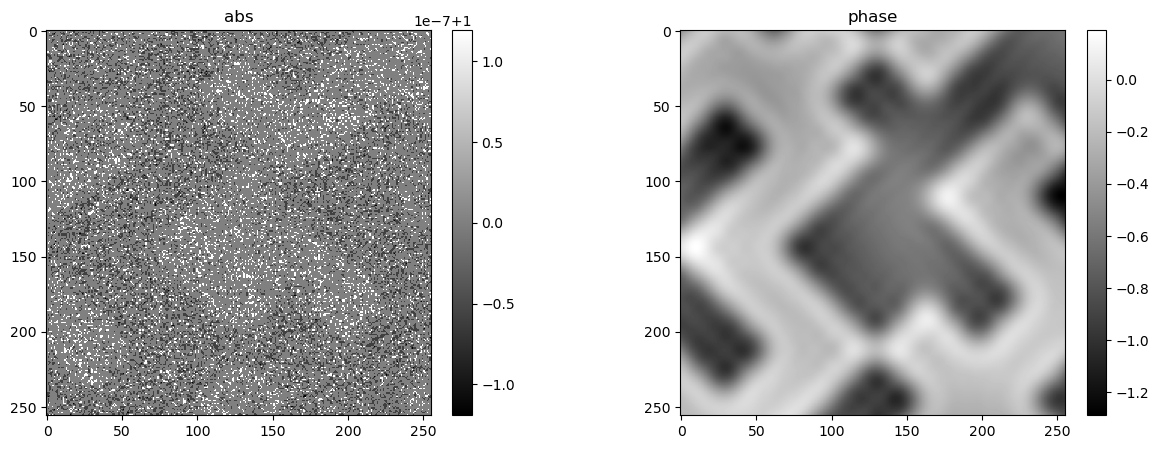

In [5]:
def rec_init(rdata,shifts):
    recMultiPaganin = cp.zeros([1,ne,ne],dtype='float32')
    recMultiPaganinr = cp.zeros([1,ne,ne],dtype='float32')# to compensate for overlap
    for j in range(0,npos):
        rdatar = cp.array(rdata[:,j:j+1])
        r = multiPaganin(rdatar,
                            distances[j:j+1], wavelength, voxelsize,  24.05, 1e-1)    
        rr = r*0+1 # to compensate for overlap
        r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
        rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
        shiftsr = cp.array(shifts[:,j])
        recMultiPaganin += ST(r,shiftsr).real
        # mshow(recMultiPaganin[0,j],show)
        recMultiPaganinr += ST(rr,shiftsr).real
        
    # recMultiPaganin = np.sum(recMultiPaganin,axis=1)
    # recMultiPaganinr = np.sum(recMultiPaganinr,axis=1)

    # frame = recMultiPaganinr>5e-2
    # avoid division by 0
    recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1
    

    # compensate for overlap
    recMultiPaganin /= recMultiPaganinr
    v = cp.ones(ne,dtype='float32')
    v[:pad] = np.sin(cp.linspace(0,1,pad)*np.pi/2)
    v[ne-pad:] = np.cos(cp.linspace(0,1,pad)*np.pi/2)
    v = np.outer(v,v)
    recMultiPaganin*=v
    recMultiPaganin = np.exp(1j*recMultiPaganin)

    return recMultiPaganin

rec_paganin = rec_init(rdata,shifts_code0)
rdata=[]
# mshow(frame[0],show)
mshow_polar(rec_paganin[0],show)
mshow_polar(rec_paganin[0,ne//2-128:ne//2+128,ne//2-128:ne//2+128],show)

# Construct operators


(131065984-45.252952575683594j)==
(131080736-5.286200757836923e-05j)
complex64
complex64
(79758832-26.05889892578125j)==
(79767048-0.0001020922718453221j)
complex64
complex64
(83879296-2.4657745361328125j)==
(83879288-0.0001241081627085805j)


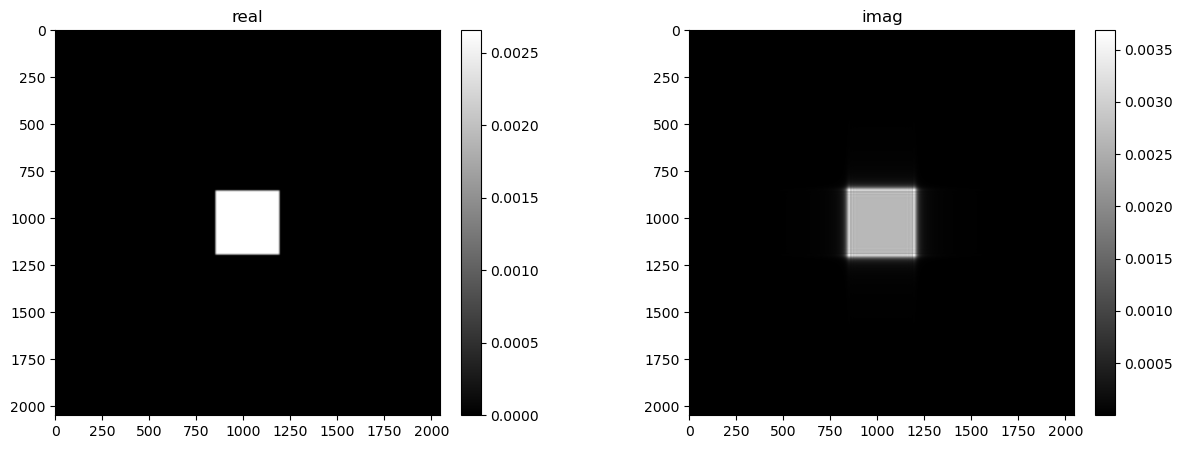

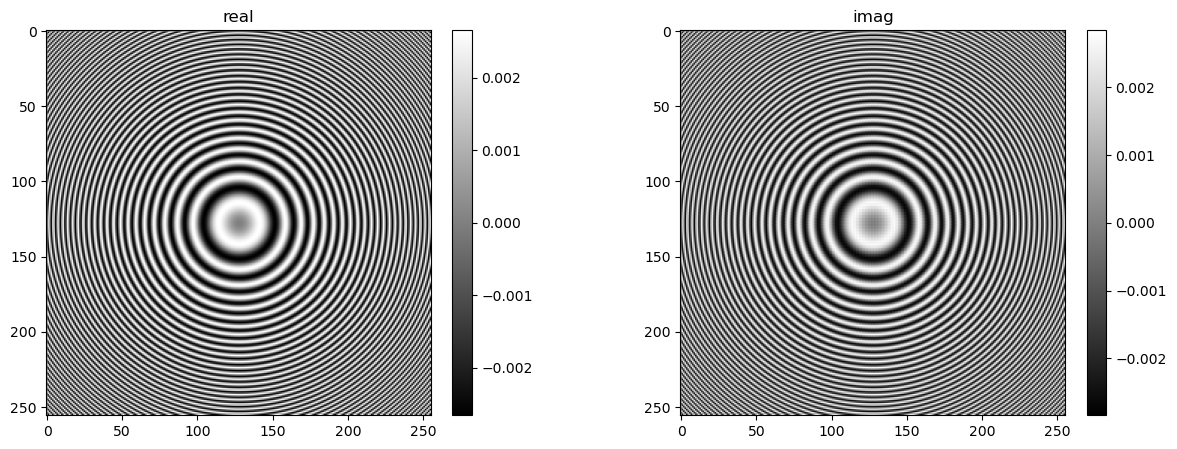

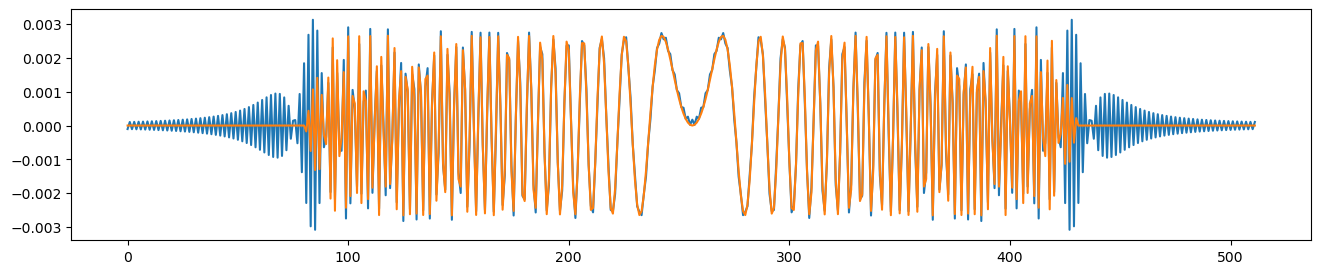

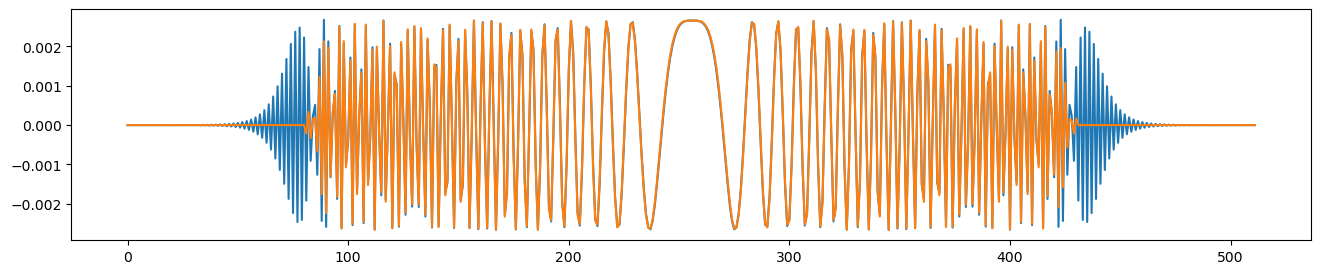

In [6]:
def L2op(psi):
    data = cp.zeros([1,npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()
        # v = cp.ones(ne,dtype='float32')
        # v[:(ne-n)//2] = cp.sin(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
        # v[-(ne-n)//2:] = cp.cos(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
        # v = cp.outer(v,v)
        # psir *= v
        psir = G(psir, wavelength, voxelsize, distances[i],'constant')        
        data[:, i] = psir[:,pad:n+pad,pad:n+pad]
    return data


def L2Top(data):
    psi = cp.zeros([1, npos, n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        datar = cp.array(cp.pad(data[:, j],((0,0),(pad,pad),(pad,pad)))).astype('complex64')        
        datar = GT(datar, wavelength, voxelsize, distances[j],'constant')        
        # v = cp.ones(ne,dtype='float32')
        # v[:(ne-n)//2] = cp.sin(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
        # v[-(ne-n)//2:] = cp.cos(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
        # v = cp.outer(v,v)        
        # datar *= v
        psi[:,j] += datar    
    return psi

def Sop(psi,ishifts,shifts):
    data = cp.zeros([1, shifts.shape[1], n+2*pad, n+2*pad], dtype='complex64')
    psi = cp.asarray(psi)
    for j in range(shifts.shape[1]):
        psir = Seop(psi,ishifts[:,j])
        shiftsr = cp.array(shifts[:, j])
        psir = S(psir, shiftsr,mode='symmetric')
        data[:,j] = psir[:,extra:-extra,extra:-extra]
    return data

def STop(data,ishifts,shifts):
    psi = cp.zeros([1, ne, ne], dtype='complex64')
    for j in range(shifts.shape[1]):
        datar = cp.asarray(data[:,j])
        shiftsr = cp.asarray(shifts[:, j])        
        psir = cp.pad(datar,((0,0),(extra,extra),(extra,extra)))     
        psir = ST(psir,shiftsr,mode='symmetric')
        SeTop(psi,psir,ishifts[:,j])
    return psi

def Seop(psi,ishifts):
    stx = ne//2-ishifts[0,1]-n//2-pad-extra
    endx = stx+n+2*pad+2*extra
    sty = ne//2-ishifts[0,0]-n//2-pad-extra
    endy = sty+n+2*pad+2*extra
    return psi[:,sty:endy,stx:endx]

def SeTop(psi,psir,ishifts):
    stx = ne//2-ishifts[0,1]-n//2-pad-extra
    endx = stx+n+2*pad+2*extra
    sty = ne//2-ishifts[0,0]-n//2-pad-extra
    endy = sty+n+2*pad+2*extra
    psi[:,sty:endy,stx:endx] += psir
    return psi


def Cop(psi,crop):
    res = psi.copy()
    res[...,crop:res.shape[-1]-crop,crop:res.shape[-1]-crop]=0
    res = psi*crop
    return res

def CTop(psi,crop):
    res = psi.copy()
    res[...,crop:res.shape[-1]-crop,crop:res.shape[-1]-crop]=0
    return res

def Cfop(psi,fcrop):
    res = psi*fcrop
    return res

def CfTop(psi,fcrop):
    res = psi*fcrop    
    return res

def Gop(psi,gltype='grad'):
    if gltype=='lap':
        stencil = cp.array([[0, 1, 0],[1, -4, 1], [0, 1, 0]])
        res = psi.copy()
        res[0] = ndimage.convolve(res[0], stencil)
    else:
        res = cp.zeros([2, *psi.shape], dtype='complex64')
        res[0, :, :, :-1] = psi[:, :, 1:]-psi[:, :, :-1]
        res[1, :, :-1, :] = psi[:, 1:, :]-psi[:, :-1, :]
    return res

def GTop(psi,gltype='grad'):
    if gltype=='lap':
        stencil = cp.array([[0, 1, 0],[1, -4, 1], [0, 1, 0]])
        res = psi.copy()
        res[0] = ndimage.convolve(res[0], stencil)
    else:
        res = cp.zeros(psi.shape[1:], dtype='complex64')
        res[:, :, 1:] = psi[0, :, :, 1:]-psi[0, :, :, :-1]
        res[:, :, 0] = psi[0, :, :, 0]
        res[:, 1:, :] += psi[1, :, 1:, :]-psi[1, :, :-1, :]
        res[:, 0, :] += psi[1, :, 0, :]
        res = -res
    return res

def Lop(psi):
    data = cp.zeros([1,npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()
        
        x = (cp.arange(-n-2*pad,n+2*pad))*voxelsize
        [y,x] = cp.meshgrid(x,x)
        P=1j*1/(wavelength*np.abs(distances[i]))*np.exp(1j*np.pi*(x**2+y**2)/(wavelength*distances[i]))/(2*n)**4/2
        v = cp.ones(2*n+4*pad)
        size_v = n//128
        size_1 = n//16+n//64
        v[:n+2*pad-size_v-size_1] = 0
        v[n+2*pad-size_v-size_1:n+2*pad-size_1] = cp.sin(cp.linspace(0,1,size_v)*cp.pi/2)        
        v[-(n+2*pad):] = v[:n+2*pad][::-1]
        v = cp.outer(v,v)
        
        P *= v
        fP = cp.fft.fft2(cp.fft.fftshift(P)                )
        fP =fP.astype('complex64')
        psir = cp.pad(psir,((0,0),(n//2+pad,n//2+pad),(n//2+pad,n//2+pad)))        
        psir = cp.fft.ifft2(cp.fft.fft2(psir)*fP)        
        data[:, i] = psir[:,2*pad+n-n//2:2*pad+n+n//2,2*pad+n-n//2:2*pad+n+n//2]
    return data

def LTop(data):
    psi = cp.zeros([1, npos, n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        
        x = (cp.arange(-n-2*pad,n+2*pad))*voxelsize
        [y,x] = cp.meshgrid(x,x)
        P=-1j*1/(wavelength*np.abs(distances[j]))*np.exp(1j*np.pi*(x**2+y**2)/(-wavelength*distances[j]))/(2*n)**4/2
        v = cp.ones(2*n+4*pad)
        size_v = n//128
        size_1 = n//16+n//64
        v[:n+2*pad-size_v-size_1] = 0
        v[n+2*pad-size_v-size_1:n+2*pad-size_1] = cp.sin(cp.linspace(0,1,size_v)*cp.pi/2)        
        v[-(n+2*pad):] = v[:n+2*pad][::-1]
        v = cp.outer(v,v)        
        P *= v        
        fP = cp.fft.fft2(cp.fft.fftshift(P)                )
        fP =fP.astype('complex64')
        psir = cp.array(cp.pad(data[:, j],((0,0),(pad,pad),(pad,pad)))).astype('complex64')        
        psir = cp.pad(psir,((0,0),(n//2+pad,n//2+pad),(n//2+pad,n//2+pad)))        
        psir = cp.fft.ifft2(cp.fft.fft2(psir)*fP)        
        psir = psir[:,2*pad+n-n//2-pad:2*pad+n+n//2+pad,2*pad+n-n//2-pad:2*pad+n+n//2+pad]
        
        psi[:,j] += psir
    return psi
# adjoint tests
arr1 = (cp.random.random([1,ne,ne])+1j*cp.random.random([1,ne,ne])).astype('complex64')
shifts_test = cp.array(shifts_code0)
ishifts_test = shifts_test.astype('int32')
shifts_test = shifts_test-ishifts_test

arr2 = Sop(arr1,ishifts_test,shifts_test)
arr3 = STop(arr2,ishifts_test,shifts_test)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = (cp.random.random([1,npos,n+2*pad,n+2*pad])+1j*cp.random.random([1,npos,n+2*pad,n+2*pad])).astype('complex64')
arr2 = Lop(arr1)
print(arr2.dtype)
arr3 = LTop(arr2)
print(arr3.dtype)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')
# arr1=arr2=arr3=[]
arr2 = L2op(arr1)
print(arr2.dtype)
arr3 = L2Top(arr2)
print(arr3.dtype)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

# arr1 = (cp.random.random([1,ne,ne])+1j*cp.random.random([1,ne,ne])).astype('complex64')
# arr2 = Gop(arr1)
# arr3 = GTop(arr2)
# print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')
# arr1=arr2=arr3=[]


   

delta = cp.zeros([1,npos,n+2*pad,n+2*pad],dtype='complex64')
delta[:,:,n//2+pad,n//2+pad] = 1
Ldelta = Lop(delta)
Ldelta2 = L2op(delta)


mshow_complex(np.abs(Ldelta[0,0])+1j*np.abs(Ldelta2[0,0]),True)
# plt.plot(np.real(Ldelta[0,0])[n//2+pad].get())
mshow_complex(np.real(Ldelta[0,0,n//2-128:n//2+128,n//2-128:n//2+128])+1j*np.real(Ldelta2[0,0,n//2-128:n//2+128,n//2-128:n//2+128]),True)

plt.figure(figsize=(16,3))
plt.plot(np.real(Ldelta2[0,0])[n//2][n//2-256:n//2+256].get())
plt.plot(np.real(Ldelta[0,0])[n//2][n//2-256:n//2+256].get())
plt.figure(figsize=(16,3))
plt.plot(np.imag(Ldelta2[0,0])[n//2][n//2-256:n//2+256].get())
plt.plot(np.imag(Ldelta[0,0])[n//2][n//2-256:n//2+256].get())

# plt.plot(np.real(Ldelta2[0,0])[n//2+pad].get())
# mshow(np.real(Ldelta2[0,0,n//2-128:n//2+128,n//2-128:n//2+128]),True)




## Reconstruction with the CG (Carlsson) with Hessians

$$ H(q,\psi,{{x}})=F(J(q)\cdot S_{{x}}(C_f^*(\psi)+\psi_{fr}))+\lambda_o\|\nabla C(\psi)\|_2^2=\left\||L(M(q,\psi,x))|-d\right\|_2^2+\lambda_o\|\nabla C(\psi)\|_2^2
$$


## Gradients

#### $$\nabla F=2 \left(L^*\left( L(M(q_0,\psi_0,\boldsymbol{x}_0))-\tilde d\right)\right).$$
#### where $$\tilde d = d \frac{L(M(q_0,\psi_0,\boldsymbol{x}_0))}{|L(M(q_0,\psi_0,\boldsymbol{x}_0))|}$$




In [7]:
def gradientF(vars,d):
    (q,psi,x,crop,psifr,ix) = (vars['prb'], vars['psi'], vars['shift'],vars['crop'],vars['psifr'],vars['ishift'])
    psie = CfTop(psi,crop[1])+psifr
    Lpsi = Lop(Sop(psie,ix,x)*q)
    td = d*(Lpsi/np.abs(Lpsi))
    res = 2*LTop(Lpsi - td)
    return res

##### $$\nabla_{\psi} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=C_f(S_{\boldsymbol{x}_{0}}^*\left(\overline{J(q_0)}\cdot \nabla F\right))+ \underline{2\lambda \nabla^T (C^T(C(\nabla(\psi))))}$$

##### $$\nabla_{q} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=J^*\left( \overline{S_{\boldsymbol{x}_{0}}(C_f^*(\psi_0)+\psi_{fr})}\cdot \nabla F\right).$$
##### $$\nabla_{\boldsymbol{x}_0} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=\textsf{Re}\Big(\big( \Big\langle \overline{q_0}\cdot \nabla F,   C(\mathcal{F}^{-1}(-2\pi i \xi_1 e^{ -2\pi i \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0}))\Big\rangle,\Big\langle \overline{q_0}\cdot \nabla F,C(\mathcal{F}^{-1}(-2\pi i \xi_2 e^{ -2\pi i \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0})) \Big\rangle\big)\Big)_{k=1}^K. $$




In [8]:
def gradientpsi(psi,q,ix,x,gradF,lam,crop):
    return Cfop(STop(np.conj(q)*gradF,ix,x),crop[1])+2*lam[0]*GTop(CTop(Cop(Gop(psi),crop[0]),crop[0]))

def gradientq(psi,psifr,q,ix,x,gradF,lam,crop):
    psie = CfTop(psi,crop[1])+psifr    
    res = np.sum(np.conj(Sop(psie,ix,x))*gradF,axis=1)
    res += 2*lam[1]*GTop(CTop(Cop(Gop(q),crop[0]),crop[0]))
    return res

def gradientx(psi,psifr,q,ix,x,gradF,crop):
    gradx = cp.zeros([1,npos,2],dtype='float32')    
    xi1 = cp.fft.fftfreq(2*(n+2*pad+2*extra)).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    psie = CfTop(psi,crop[1])+psifr    

    for j in range(npos):        
        psir = Seop(psie,ix[:,j])        
        psir = cp.pad(psir, ((0, 0), (n//2+pad+extra, n//2+pad+extra), (n//2+pad+extra, n//2+pad+extra)),'symmetric')
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))      
        t = cp.fft.ifft2(pp*xi1*cp.fft.fft2(psir))
        nee = t.shape[-1]
        t = t[:,nee//2-n//2-pad:nee//2+n//2+pad,nee//2-n//2-pad:nee//2+n//2+pad]
        gradx[:,j,0] = -2*np.pi*imdot(gradF[:,j],q*t,axis=(1,2))    
    
    for j in range(npos):        
        psir = Seop(psie,ix[:,j])
        psir = cp.pad(psir, ((0, 0), (n//2+pad+extra, n//2+pad+extra), (n//2+pad+extra, n//2+pad+extra)),'symmetric')
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))                            
        t = cp.fft.ifft2(pp*xi2*cp.fft.fft2(psir))
        nee = t.shape[-1]
        t = t[:,nee//2-n//2-pad:nee//2+n//2+pad,nee//2-n//2-pad:nee//2+n//2+pad]
        gradx[:,j,1] = -2*np.pi*imdot(gradF[:,j],q*t,axis=(1,2))    

    return gradx

    
def gradients(vars,d,gradF):
    (q,psi,x,rho,lam,crop,psifr,ix) = (vars['prb'], vars['psi'], vars['shift'],vars['rho'],vars['lam'],vars['crop'],vars['psifr'],vars['ishift'])
    grads = {}
    
    grads['psi'] = rho[0]*gradientpsi(psi,q,ix,x,gradF,lam,crop)
    grads['prb'] = rho[1]*gradientq(psi,psifr,q,ix,x,gradF,lam,crop)
    grads['shift'] = rho[2]*gradientx(psi,psifr,q,ix,x,gradF,crop)
    return grads



##### $$\frac{1}{2}\mathcal{H}|_{x_0}(y,z)= \left\langle \mathbf{1}-d_{0}, \mathsf{Re}({L(y)}\overline{L(z)})\right\rangle+\left\langle d_{0},(\mathsf{Re} (\overline{l_0}\cdot L(y)))\cdot (\mathsf{Re} (\overline{l_0}\cdot L(z))) \right\rangle$$
##### $$l_0=L(x_0)/|L(x_0)|$$
##### $$d_0=d/|L(x_0)|$$


In [9]:
def hessianF(hpsi,hpsi1,hpsi2,data):
    Lpsi = Lop(hpsi)        
    Lpsi1 = Lop(hpsi1)
    Lpsi2 = Lop(hpsi2)    
    l0 = Lpsi/np.abs(Lpsi)
    d0 = data/np.abs(Lpsi)
    v1 = np.sum((1-d0)*reprod(Lpsi1,Lpsi2))
    v2 = np.sum(d0*reprod(l0,Lpsi1)*reprod(l0,Lpsi2))        
    return 2*(v1+v2)

##### $D T_\psi|_{{{z}_0}}(\Delta {z})=-2\pi iC\Big(\mathcal{F}^{-1}\big({\Delta z \cdot \xi}) e^{-2\pi i  {z}_0\cdot {\xi}}\hat{\psi}({\xi})\big)\Big)=-2\pi i C\Big(\mathcal{F}^{-1}\big((\Delta z_1 {\xi_1}+\Delta z_2 {\xi_2}) e^{-2\pi i  {z}_0\cdot {\xi}}\hat{\psi}({\xi})\big)\Big)$
##### $ D^2{T_\psi}|_{{{z}_0}}(\Delta{z},\Delta{w})=-4\pi^2C(\mathcal{F}^{-1}((\Delta{z}\cdot\xi)(\Delta{w}\cdot\xi)e^{-2\pi i  {z}_0\cdot {\xi}}\hat{\psi}))$
##### $=-4\pi^2C(\mathcal{F}^{-1}((\Delta{z_1}\Delta{w_1}\xi_1^2 + (\Delta{z_1}\Delta{w_2}+\Delta{z_2}\Delta{w_1})\xi_1\xi_2+\Delta{z_2}\Delta{w_2}\xi_2^2)\hat{\psi}))$

In [10]:
def DT(psi,ix,x,dx):
    res = cp.zeros([1,npos,n+2*pad,n+2*pad],dtype='complex64')
    xi1 = cp.fft.fftfreq(2*(n+2*pad+2*extra)).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    for j in range(npos):
        psir = Seop(psi,ix[:,j])
        psir = cp.pad(psir, ((0, 0), (n//2+pad+extra, n//2+pad+extra), (n//2+pad+extra, n//2+pad+extra)),'symmetric')
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        dxj = cp.array(dx[:,j,:,np.newaxis,np.newaxis])

        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))    
        xiall = xi1*dxj[:,0]+xi2*dxj[:,1]

        psir = cp.fft.ifft2(pp*xiall*cp.fft.fft2(psir))   
        nee = psir.shape[-1]
        psir = psir[:,nee//2-n//2-pad:nee//2+n//2+pad,nee//2-n//2-pad:nee//2+n//2+pad]
        res[:,j] = -2*np.pi*1j*psir
    return res

def D2T(psi,ix,x,dx1,dx2):
    res = cp.zeros([1,npos,n+2*pad,n+2*pad],dtype='complex64')
    xi1 = cp.fft.fftfreq(2*(n+2*pad+2*extra)).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    for j in range(npos):
        psir = Seop(psi,ix[:,j])
        psir = cp.pad(psir, ((0, 0), (n//2+pad+extra, n//2+pad+extra), (n//2+pad+extra, n//2+pad+extra)),'symmetric')
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        dx1j = cp.array(dx1[:,j,:,np.newaxis,np.newaxis])
        dx2j = cp.array(dx2[:,j,:,np.newaxis,np.newaxis])

        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))    
        xiall = xi1**2*dx1j[:,0]*dx2j[:,0]+ \
                xi1*xi2*(dx1j[:,0]*dx2j[:,1]+dx1j[:,1]*dx2j[:,0])+ \
                xi2**2*dx1j[:,1]*dx2j[:,1]

        psir = cp.fft.ifft2(pp*xiall*cp.fft.fft2(psir))   
        nee = psir.shape[-1]
        psir = psir[:,nee//2-n//2-pad:nee//2+n//2+pad,nee//2-n//2-pad:nee//2+n//2+pad]
        res[:,j] = -4*np.pi**2*psir
    return res

#### $$ DM|_{(q_0,\psi_0,\boldsymbol{x})}(\Delta q, \Delta \psi,\Delta\boldsymbol{x})=$$
#### $$ \Big(\Delta q\cdot T_{\psi_0}({\boldsymbol{x}_{0,k}})+ q_0\cdot \big(T_{\Delta \psi}({\boldsymbol{x}_{0,k}})+  DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k)\big) \Big)_{k=1}^K=$$
#### $$ J(\Delta q)\cdot S_{\boldsymbol{x}_{0,k}}(\psi_0)+ J(q_0)\cdot S_{\boldsymbol{x}_{0}}{(\Delta \psi)}+  \Big(q_0\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k) \Big)_{k=1}^K$$


In [11]:
def DM(psi,q,ix,x,dpsi,dq,dx):
    res = dq*Sop(psi,ix,x)+q*(Sop(dpsi,ix,x)+DT(psi,ix,x,dx))   
    return res

##### $$ D^2M|_{(q_0,\psi_0,\boldsymbol{x})}\big((\Delta q^{(1)}, \Delta \psi^{(1)},\Delta\boldsymbol{x}^{(1)}),(\Delta q^{(2)}, \Delta \psi^{(2)},\Delta\boldsymbol{x}^{(2)})\big)= $$
##### $$\Big( q_0\cdot DT_{\Delta\psi^{(1)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+q_0\cdot DT_{\Delta\psi^{(2)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})+ q_0\cdot D^2{T_\psi}|_{{\boldsymbol{x}_0}}(\Delta\boldsymbol{x}^{(1)},\Delta\boldsymbol{x}^{(2)})+$$
##### $$\Delta q^{(1)}\cdot T_{\Delta \psi^{(2)}}({\boldsymbol{x}_{0,k}})+\Delta q^{(2)}\cdot T_{\Delta \psi^{(1)}}({\boldsymbol{x}_{0,k}})+ $$
##### $$\Delta q^{(1)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+\Delta q^{(2)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})\Big)_{k=1}^K.$$


In [12]:
def D2M(psi,q,ix,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2):    
    res =  q*DT(dpsi1,ix,x,dx2) + q*DT(dpsi2,ix,x,dx1) + q*D2T(psi,ix,x,dx1,dx2)  
    res += dq1*Sop(dpsi2,ix,x) + dq2*Sop(dpsi1,ix,x) 
    res += dq1*DT(psi,ix,x,dx2) + dq2*DT(psi,ix,x,dx1)
    return res

##### $$\mathcal{H}^G|_{ (q_0,\psi_0,\boldsymbol{x}_0)}\Big((\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)=$$
##### $$\Big\langle \nabla F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}, D^2M|_{(q_0,C_f^*(\psi_0),\boldsymbol{x}_0)}\Big((\Delta q^{(1)},C_f^*(\Delta \psi^{(1)}),\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},C_f^*(\Delta \psi^{(2)}),\Delta \boldsymbol{x}^{(2)})\Big)\Big\rangle +$$
##### $$\mathcal{H}^F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}\Big(DM|_{(q_0,C_f^*(\psi_0),\boldsymbol{x}_0)}(\Delta q^{(1)},C_f^*(\Delta \psi^{(1)}),\Delta \boldsymbol{x}^{(1)}),DM|_{(q_0,\psi_0,\boldsymbol{x}_0)}(\Delta q^{(2)},C_f^*(\Delta \psi^{(2)}),\Delta \boldsymbol{x}^{(2)})\Big)+$$
##### $$+\underline{2\lambda \textsf{Re}\langle C(\nabla  (\Delta \psi^{(1)})),C(\nabla ( \Delta \psi^{(2)}))\rangle}$$

### Updates:

\begin{equation}
               \alpha_j=\frac{\mathsf{Re}\langle \nabla F|_{x_j},s_j\rangle}{H|_{x_j}( {s_j},s_j)}
             \end{equation}

\begin{equation}
                \beta_j=\frac{H(\nabla F|_{x_j},s_j)}{H|_{x_j}( {s_j},s_j)}.
\end{equation}

### Scaling variables:

\begin{equation}
\begin{aligned}
\tilde{\beta}_j=\frac{H^{\tilde{F}}|_{\tilde{x}_j} (\nabla \tilde{F}|_{\tilde{x}_j},\tilde{\eta}_j)}{H^{\tilde{F}}|_{\tilde{x}_j} (\tilde{\eta}_j,\tilde{\eta}_j)}=\frac{H^{F}|_{x_j} (\rho\nabla \tilde{F}|_{\tilde{x}_j},\rho\tilde{\eta}_j)}{H^{F}|_{x_j} (\rho\tilde{\eta}_j,\rho\tilde{\eta}_j)}=\frac{H^{F}|_{x_j} (\rho^2\nabla F|_{x_j},\rho\tilde{\eta}_j)}{H^{F}|_{x_j} (\rho\tilde{\eta}_j,\rho\tilde{\eta}_j)}
\end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
\tilde{\alpha}_j=\frac{\langle\nabla \tilde{F}|_{\tilde{x}_j},\tilde{\eta}_j\rangle}{H^{\tilde{F}}|_{\tilde{x}_j} (\tilde{\eta}_j,\tilde{\eta}_j)}=\frac{\langle \rho\nabla F|_{x_j},\tilde{\eta}_j\rangle}{H^{F}|_{x_j} (\rho\tilde{\eta}_j,\rho\tilde{\eta}_j)}
\end{aligned}
\end{equation}

\begin{equation}
    \begin{aligned}
        \tilde{\eta}_{j+1} = -\nabla \tilde{F}|_{\tilde{x}_j}+\tilde{\beta}_j\tilde{\eta}_j=-\rho\nabla F|_{x_j}+\tilde{\beta}_j\tilde{\eta}_j,\quad \text{with } \tilde{\eta}_0=-\rho\nabla F|_{x_0}
    \end{aligned}
\end{equation}

\begin{equation}
    \begin{aligned}
        \tilde{x}_{j+1} = \tilde{x}_{j}+\tilde{\alpha}_j\tilde{\eta}_{j+1}
    \end{aligned}
\end{equation}

Multiplying both sides by $\rho$,

\begin{equation}
    \begin{aligned}
        x_{j+1} = x_j+\rho\tilde{\alpha}_j\tilde{\eta}_{j+1}
    \end{aligned}
\end{equation}

In [13]:
def calc_beta(vars,grads,etas,d,gradF):
    (q,psi,x,rho,lam,crop,psifr,ix) = (vars['prb'], vars['psi'], vars['shift'],vars['rho'],vars['lam'],vars['crop'],vars['psifr'],vars['ishift'])    
    (dpsi1,dq1,dx1) = (grads['psi']*rho[0], grads['prb']*rho[1], grads['shift']*rho[2])
    (dpsi2,dq2,dx2) = (etas['psi']*rho[0], etas['prb']*rho[1], etas['shift']*rho[2])
    
    # beta = top/bottom
    top = 0
    bottom = 0

    # 1. regularization term
    gpsi1 = Cop(Gop(dpsi1),crop[0])
    gpsi2 = Cop(Gop(dpsi2),crop[0])
    gq1 = Cop(Gop(dq1),crop[0])
    gq2 = Cop(Gop(dq2),crop[0])
    top += 2*lam[0]*redot(gpsi1,gpsi2)+2*lam[1]*redot(gq1,gq2)
    bottom += 2*lam[0]*redot(gpsi2,gpsi2)+2*lam[1]*redot(gq2,gq2)
    
    gpsi1=[]
    gpsi2=[]

    # 2. frame psi and dpsi
    psi = CfTop(psi,crop[1])+psifr
    dpsi1 = CfTop(dpsi1,crop[1])
    dpsi2 = CfTop(dpsi2,crop[1])


    d2m1 = D2M(psi,q,ix,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2)
    top += redot(gradF,d2m1)        
    d2m1 = []

    d2m2 = D2M(psi,q,ix,x,dpsi2,dq2,dx2,dpsi2,dq2,dx2)
    bottom += redot(gradF,d2m2)    
    d2m2=[]

    # 3. calculate DM, D2M
    dm1 = DM(psi,q,ix,x,dpsi1,dq1,dx1)
    dm2 = DM(psi,q,ix,x,dpsi2,dq2,dx2)
        
    # 4. finalize computation by the formula
    sq = Sop(psi,ix,x)*q
    top += hessianF(sq, dm1, dm2,d)        
    
    bottom += hessianF(sq, dm2, dm2,d)
    
    return top/bottom

def calc_alpha(vars,grads,etas,d,gradF):    
    (q,psi,x,rho,lam,crop,psifr,ix) = (vars['prb'], vars['psi'], vars['shift'],vars['rho'],vars['lam'],vars['crop'],vars['psifr'],vars['ishift'])    
    (dpsi1,dq1,dx1) = (grads['psi'], grads['prb'], grads['shift'])
    (dpsi2,dq2,dx2) = (etas['psi'], etas['prb'], etas['shift']) 

    # beta = top/bottom
    top = 0
    bottom = 0
    
    # 1. top part, doesn't include frame and srho scaling
    top = -redot(dpsi1,dpsi2)-redot(dq1,dq2)-redot(dx1,dx2)
    
    # 2. scale variable fo the hessian
    (dpsi2,dq2,dx2) = (etas['psi']*rho[0], etas['prb']*rho[1], etas['shift']*rho[2])

    # 3. regularization term
    gpsi2 = Cop(Gop(dpsi2),crop[0])
    gq2 = Cop(Gop(dq2),crop[0])
    bottom += 2*lam[0]*redot(gpsi2,gpsi2)
    bottom += 2*lam[1]*redot(gq2,gq2)
    gpsi2 = []
    
    # 4. frame psi and dpsi
    psi = CfTop(psi,crop[1])+psifr
    dpsi2 = CfTop(dpsi2,crop[1])

    d2m2 = D2M(psi,q,ix,x,dpsi2,dq2,dx2,dpsi2,dq2,dx2)
    bottom += redot(gradF,d2m2)
    d2m2 = []

    # 5. calculate DM, D2M
    dm2 = DM(psi,q,ix,x,dpsi2,dq2,dx2)    

    # 6. finalize computation by the formula
    sq = Sop(psi,ix,x)*q    
    
    bottom += hessianF(sq, dm2, dm2,d)
    
    return top/bottom, top, bottom

## debug functions

In [14]:
def plot_debug2(vars,etas,top,bottom,alpha,data):
    '''Check the minimization functional behaviour'''

    if show==False:
        return
    (q,psi,x,rho,crop,psifr,ix,lam) = (vars['prb'], vars['psi'], vars['shift'],vars['rho'],vars['crop'],vars['psifr'],vars['ishift'],vars['lam'])
    (dpsi2,dq2,dx2) = (etas['psi'],etas['prb'],etas['shift'])
    npp = 3
    errt = cp.zeros(npp*2)
    errt2 = cp.zeros(npp*2)
    for k in range(0,npp*2):
        psit = psi+(alpha*k/(npp-1))*rho[0]*dpsi2
        qt = q+(alpha*k/(npp-1))*rho[1]*dq2
        xt = x+(alpha*k/(npp-1))*rho[2]*dx2

        gpsit = Cop(Gop(psit),crop[0])
        
        psit = CfTop(psit,crop[1])+psifr
        fpsit = np.abs(Lop(Sop(psit,ix,xt)*qt))-data
        gqt = Cop(Gop(qt),crop[0])   

        errt[k] = np.linalg.norm(fpsit)**2
        errt[k] +=lam[0]*np.linalg.norm(gpsit)**2
        errt[k] +=lam[1]*np.linalg.norm(gqt)**2

    gpsi = Cop(Gop(psi),crop[0])

    psi = CfTop(psi,crop[1])+psifr    
    t = alpha*(cp.arange(2*npp))/(npp-1)
    fpsi = np.abs(Lop(Sop(psi,ix,x)*q))-data
    gq = Cop(Gop(q),crop[0])    
    errt2 = np.linalg.norm(fpsi)**2    
    errt2 += lam[0]*np.linalg.norm(gpsi)**2
    errt2 += lam[1]*np.linalg.norm(gq)**2
    errt2 = errt2 -top*t+0.5*bottom*t**2
    
    plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt.get(),'.')
    plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt2.get(),'.')
    plt.show()

def plot_debug3(shifts,shifts_init):
    '''Current errors in shifts'''

    if show==False:
        return
    plt.plot(shifts_init[0,:,0].get()-(shifts[0,:,0].get()),'r.')
    plt.plot(shifts_init[0,:,1].get()-(shifts[0,:,1].get()),'b.')
    plt.show()

def vis_debug(vars,i):
    '''Visualization and data saving'''

    psie = CfTop(vars['psi'],vars['crop'][1])+vars['psifr']
    mshow_polar(psie[0],show)
    mshow_polar(psie[0,ne//2-n//8:ne//2+n//8,ne//2+n//4:ne//2+n//2],show)
    mshow_polar(vars['prb'][0],show)
    dxchange.write_tiff(np.angle(psie).get(),f'{path_out}_{flg}/crec_psi_angle/{i:03}',overwrite=True)
    dxchange.write_tiff(np.abs(psie).get(),f'{path_out}_{flg}/crec_psi_abs/{i:03}',overwrite=True)
    dxchange.write_tiff(np.angle(vars['prb']).get(),f'{path_out}_{flg}/crec_prb_angle/{i:03}',overwrite=True)
    dxchange.write_tiff(np.abs(vars['prb']).get(),f'{path_out}_{flg}/crec_prb_abs/{i:03}',overwrite=True)
    np.save(f'{path_out}_{flg}/crec_shift_{i:03}',vars['shift'])
    np.save(f'{path_out}_{flg}/crec_ishift_{i:03}',vars['ishift'])
    
def err_debug(vars, grads, data):    
    '''Print error'''    
    (q,psi,x,rho,crop,psifr,ix,lam) = (vars['prb'], vars['psi'], vars['shift'],vars['rho'],vars['crop'],vars['psifr'],vars['ishift'],vars['lam'])
    gpsi = Cop(Gop(psi),crop[0])
    psi = CfTop(psi,crop[1])+psifr
    fpsi = np.abs(Lop(Sop(psi,ix,x)*q))-data
    gq = Cop(Gop(q),crop[0])
    err = np.linalg.norm(fpsi)**2    
    err += lam[0]*np.linalg.norm(gpsi)**2   
    err += lam[1]*np.linalg.norm(gq)**2 
    
    print(f'gradient norms (psi, prb, shift): {np.linalg.norm(grads['psi']):.2f}, {np.linalg.norm(grads['prb']):.2f}, {np.linalg.norm(grads['shift']):.2f}')                        
    return err

# Main CG loop (fifth rule)

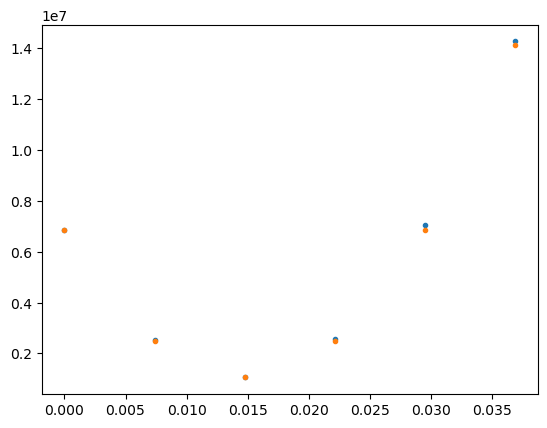

gradient norms (psi, prb, shift): 10820.98, 25893.03, 751.62
0) alpha=0.01475, [1, 1, 0.1] err=1.07354e+06


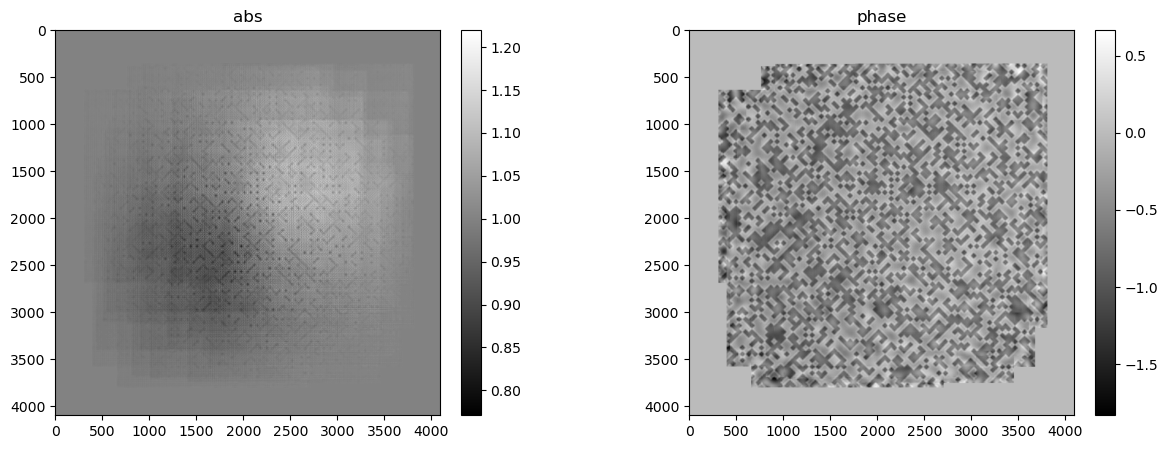

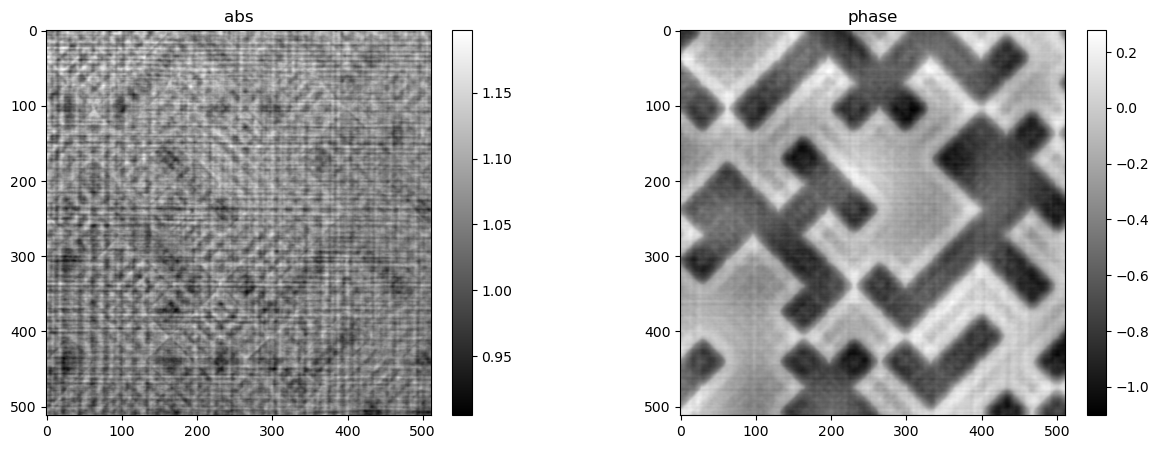

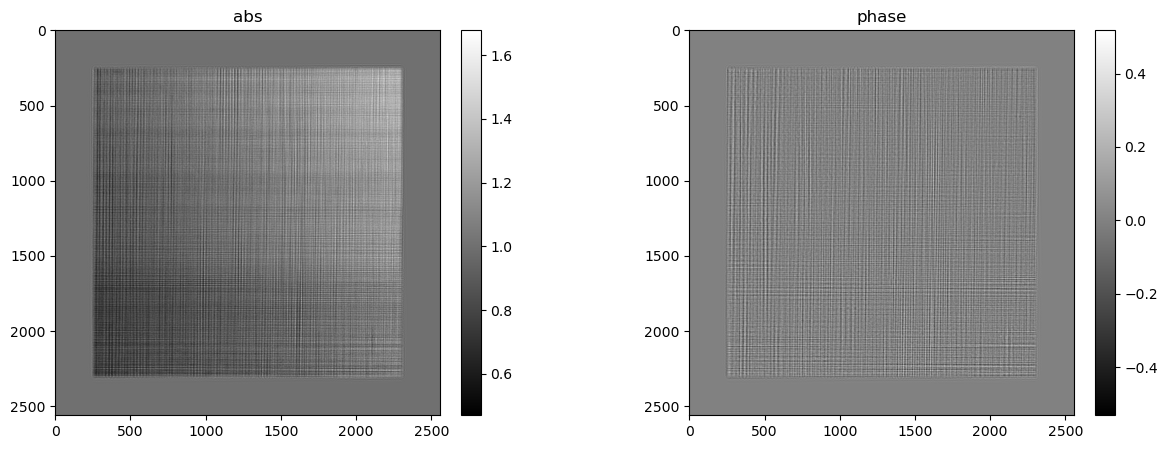

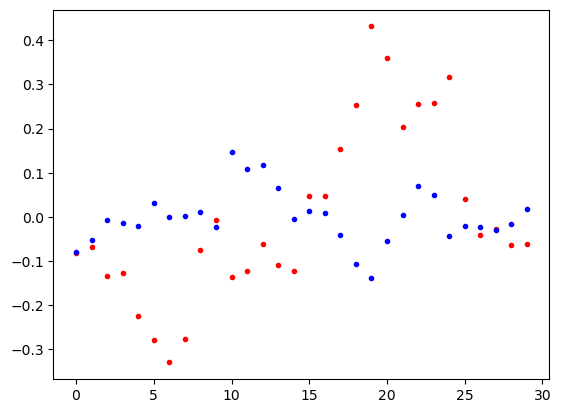

In [ ]:
def cg_holo(data, vars, pars):
    
    # work with sqrt of data
    data = np.sqrt(data)    
    
    erra = cp.zeros(pars['niter'])
    alphaa = cp.zeros(pars['niter'])    
    shifts_init = vars['shift'].copy()

    for i in range(pars['niter']):    
        
        # if i==128:
        #     vars['crop'][0]=pad//2# = np.array([pad//2,ne//2-n//2-pad//2])        

        gradF = gradientF(vars,data)        
        grads = gradients(vars,data,gradF)
    
        if i==0:# or i==512:
            etas = {}
            etas['psi'] = -grads['psi']
            etas['prb'] = -grads['prb']
            etas['shift'] = -grads['shift']
        else:      
            beta = calc_beta(vars, grads, etas, data, gradF)
            etas['psi'] = -grads['psi'] + beta*etas['psi']
            etas['prb'] = -grads['prb'] + beta*etas['prb']
            etas['shift'] = -grads['shift'] + beta*etas['shift']

        alpha,top,bottom = calc_alpha(vars, grads, etas, data, gradF) 
        if i % pars['vis_step'] == 0 and pars['vis_step'] != -1:
            plot_debug2(vars,etas,top,bottom,alpha,data)

        vars['psi'] += vars['rho'][0]*alpha*etas['psi']
        vars['prb'] += vars['rho'][1]*alpha*etas['prb']
        vars['shift'] += vars['rho'][2]*alpha*etas['shift']
        
        if i % pars['err_step'] == 0 and pars['err_step'] != -1:
            err = err_debug(vars, grads, data)    
            print(f'{i}) {alpha=:.5f}, {vars['rho']} {err=:1.5e}',flush=True)
            erra[i] = err
            alphaa[i] = alpha

        if i % pars['vis_step'] == 0 and pars['vis_step'] != -1:
            vis_debug(vars, i)
            if vars['rho'][2]>0:
                plot_debug3(vars['shift'],shifts_init)                         
            
    return vars,erra,alphaa

vars = {}
frame = cp.ones(rec_paganin.shape,dtype='float32')
vars['crop'] = [0,cp.array(frame).astype('float32')]
# mshow(frame[0],show)
vars['psi'] = rec_paganin#[:,vars['crop'][1]:ne-vars['crop'][1],vars['crop'][1]:ne-vars['crop'][1]]
vars['psifr'] = 1-frame.astype('float32')
# vars['psifr'][vars['crop'][1]:ne-vars['crop'][1],vars['crop'][1]:ne-vars['crop'][1]]=0
vars['prb'] = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')  

shifts_test = cp.array(shifts_code0)
ishifts_test = shifts_test.astype('int32')
shifts_test = shifts_test-ishifts_test

vars['ishift'] = cp.array(shifts_code0).astype('int32') 
vars['shift'] = cp.array(shifts_code0)-cp.array(shifts_code0).astype('int32') 
vars['rho'] = [1,1,0.1]
vars['lam'] = [lam_psi,lam_prb]
data_rec = cp.array(data)
pars = {'niter': 10000, 'err_step': 32, 'vis_step': 128}

%load_ext line_profiler
%lprun -f cg_holo cg_holo(data_rec, vars, pars)   

# use only the middle part to adjust the probe

In [ ]:
# iter = 32
# psi_abs = dxchange.read_tiff(f'{path_out}_{flg}/crec_psi_abs/{iter:03}.tiff')
# psi_angle = dxchange.read_tiff(f'{path_out}_{flg}/crec_psi_angle/{iter:03}.tiff')
# psi = psi_abs*np.exp(1j*psi_angle)

# prb_abs = dxchange.read_tiff(f'{path_out}_{flg}/crec_prb_abs/{iter:03}.tiff')
# prb_angle = dxchange.read_tiff(f'{path_out}_{flg}/crec_prb_angle/{iter:03}.tiff')
# prb = prb_abs*np.exp(1j*prb_angle)

# ishifts_test = np.load(f'{path_out}_{flg}/crec_ishift_{iter:03}.npy')
# shifts_test = np.load(f'{path_out}_{flg}/crec_shift_{iter:03}.npy')
# shifts_code0 = ishifts_test+shifts_test

# nee = (2048+512+256)//(2048//n)+2*pad
# ids = np.where((np.abs(shifts_code0[0,:,0])<nee//2-n//2-pad-extra)*(np.abs(shifts_code0[0,:,1])<nee//2-n//2-pad-extra))[0]#[0:2]
# data_new = data[:,ids]
# shifts_code0 = shifts_code0[:,ids]
# ishifts_test = ishifts_test[:,ids]
# shifts_test = shifts_test[:,ids]


# plt.plot(shifts_code0[0,:,0],shifts_code0[0,:,1],'.')
# plt.axis('square')
# plt.show()

# npos = len(ids)
# print(f'{npos=}')
# print(np.amin(shifts_code0[0,:,0]),np.amax(shifts_code0[0,:,0]))
# print(np.amin(shifts_code0[0,:,1]),np.amax(shifts_code0[0,:,1]))
# print(ne)
# print(np.amin(ne//2-n//2-pad-extra-shifts_code0[0,:,0]),np.amax(ne//2+n//2+pad+extra+shifts_code0[0,:,0]))
# print(np.amin(ne//2-n//2-pad-extra-shifts_code0[0,:,1]),np.amax(ne//2+n//2+pad+extra+shifts_code0[0,:,1]))

# flg = f'{ne}_{pad}_{npos}'
# print(flg)

# vars['crop'] = [0,0]
# vars['psi'] = cp.array(psi)
# vars['psifr'] = cp.ones([ne,ne],dtype='complex64')
# vars['psifr'][vars['crop'][1]:ne-vars['crop'][1],vars['crop'][1]:ne-vars['crop'][1]]=0
# vars['prb'] = cp.array(prb)


# vars['ishift'] = cp.array(ishifts_test)
# vars['shift'] = cp.array(shifts_test)
# vars['rho'] = [0,1,0.1]
# vars['lam'] = 0
# data_rec = cp.array(data_new)
# pars = {'niter': 65, 'err_step': 16, 'vis_step': 32}

# %load_ext line_profiler
# %lprun -f cg_holo cg_holo(data_rec, vars, pars)   

In [ ]:
# import scipy as sp

# def _downsample(data, binning):
#     res = data.copy()
#     for k in range(binning):
#         res = 0.5*(res[..., ::2,:]+res[..., 1::2,:])
#         res = 0.5*(res[..., :, ::2]+res[..., :, 1::2])
#     return res

# def _fftupsample(f, dims):
#     paddim = np.zeros([np.ndim(f), 2], dtype='int32')
#     dims = np.asarray(dims).astype('int32')
#     paddim[dims, 0] = np.asarray(f.shape)[dims]//2
#     paddim[dims, 1] = np.asarray(f.shape)[dims]//2
#     fsize = f.size
#     f = sp.fft.ifftshift(sp.fft.fftn(sp.fft.fftshift(
#         f, dims), axes=dims, workers=-1), dims)
#     f = np.pad(f, paddim)
#     f = sp.fft.fftshift(f, dims)
#     f = sp.fft.ifftn(f, axes=dims, workers=-1)
#     f = sp.fft.ifftshift(f, dims)
#     return f.astype('complex64')*(f.size/fsize)

# nlevels = 1
# iters = np.array([4097])
# vis_steps = [64]


# # init with most binned
# n = n0//2**(nlevels-1)
# pad =pad0//2**(nlevels-1)
# ne = ne0//2**(nlevels-1)
# voxelsize = voxelsize0*2**(nlevels-1)

# vars = {}
# vars['crop'] = np.array([n//2+pad//2,pad//2])
# rec = _downsample(cp.asarray(rec_paganin),nlevels-1).astype('complex64')
# vars['psi'] = rec[:,vars['crop'][1]:ne-vars['crop'][1],vars['crop'][1]:ne-vars['crop'][1]]
# vars['psifr'] = cp.ones([ne,ne],dtype='complex64')
# vars['psifr'][vars['crop'][1]:ne-vars['crop'][1],vars['crop'][1]:ne-vars['crop'][1]]=0


# vars['shift'] = shifts/2**(nlevels-1)

# vars['prb'] = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
# vars['rho'] = [1,1,0.03]
# vars['lam'] = [lam1,lam2]


# for level in range(nlevels):
#     print(f'{level=}')
#     data_bin = _downsample(cp.asarray(data),nlevels-level-1)    
#     ref_bin = _downsample(cp.asarray(ref),nlevels-level-1)        
#     pars = {'niter': iters[level], 'err_step': vis_steps[level], 'vis_step': vis_steps[level]}

#     vars,erra,alpha = cg_holo(data_bin,ref_bin, vars, pars)    
#     if level==nlevels-1:
#         break
    
#     vars['psi'] = cp.asarray(_fftupsample(vars['psi'].get(),[1]))
#     vars['psi'] = cp.asarray(_fftupsample(vars['psi'].get(),[2]))
    
#     vars['prb'] = cp.asarray(_fftupsample(vars['prb'].get(),[1]))
#     vars['prb'] = cp.asarray(_fftupsample(vars['prb'].get(),[2]))
    
#     vars['shift']*=2
#     vars['crop']*=2
#     n*=2
#     ne*=2
#     pad*=2
#     voxelsize/=2
#     vars['psifr'] = 1*cp.ones([ne,ne],dtype='complex64')
#     vars['psifr'][vars['crop'][1]:ne-vars['crop'][1],vars['crop'][1]:ne-vars['crop'][1]]=0
    